# Project 2 source code

## Load data

In [1]:
from data import *

## part 1 a)

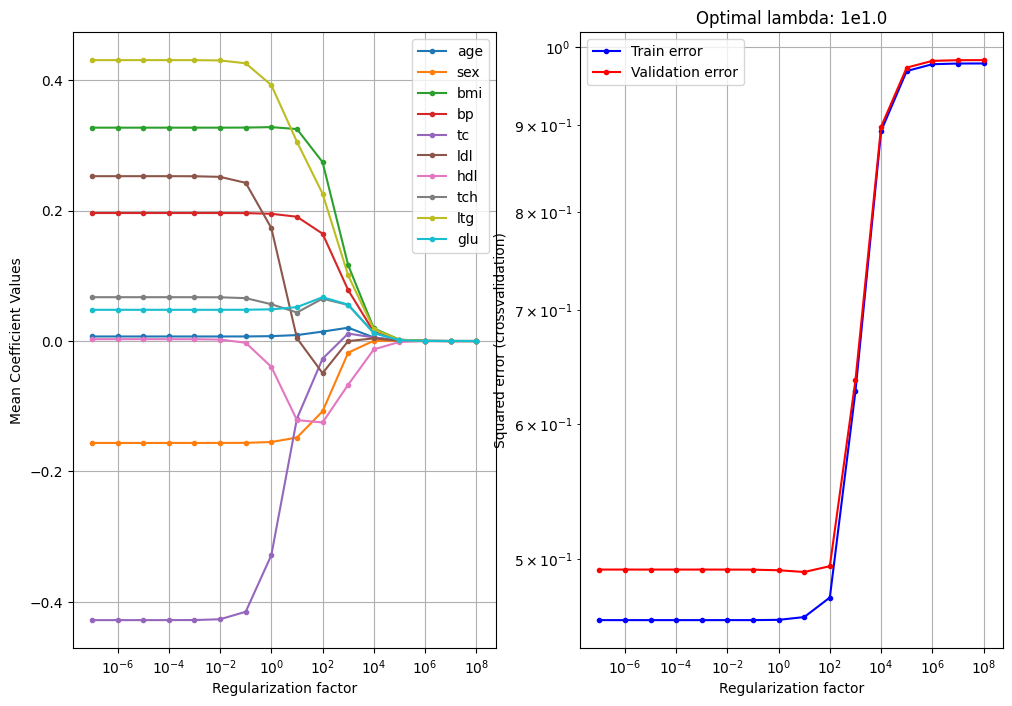

In [4]:
import pandas as pd
import numpy as np
import sklearn.linear_model as lm
from matplotlib.pylab import (
    figure,
    grid,
    legend,
    loglog,
    semilogx,
    show,
    subplot,
    title,
    xlabel,
    ylabel,
)
from scipy.io import loadmat
from sklearn import model_selection
from dtuimldmtools import rlr_validate


## Crossvalidation
# Create crossvalidation partition for evaluation
K = 10
CV = model_selection.KFold(K, shuffle=True)
# CV = model_selection.KFold(K, shuffle=False)
np.random.seed(2)
# Values of lambda
lambdas = np.power(10.0, range(-7, 9))

# Initialize variables
# T = len(lambdas)
Error_train = np.empty((K, 1))
Error_test = np.empty((K, 1))
Error_train_rlr = np.empty((K, 1))
Error_test_rlr = np.empty((K, 1))
Error_train_nofeatures = np.empty((K, 1))
Error_test_nofeatures = np.empty((K, 1))
w_rlr = np.empty((M, K))
mu = np.empty((K, M - 1))
sigma = np.empty((K, M - 1))
w_noreg = np.empty((M, K))

k = 0
for train_index, test_index in CV.split(X, y):
    # extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    internal_cross_validation = 10

    (
        opt_val_err,
        opt_lambda,
        mean_w_vs_lambda,
        train_err_vs_lambda,
        test_err_vs_lambda,
    ) = rlr_validate(X_train, y_train, lambdas, internal_cross_validation)

    # Standardize outer fold based on training set, and save the mean and standard
    # deviations since they're part of the model (they would be needed for
    # making new predictions) - for brevity we won't always store these in the scripts
    mu[k, :] = np.mean(X_train[:, 1:], 0)
    sigma[k, :] = np.std(X_train[:, 1:], 0)

    X_train[:, 1:] = (X_train[:, 1:] - mu[k, :]) / sigma[k, :]
    X_test[:, 1:] = (X_test[:, 1:] - mu[k, :]) / sigma[k, :]

    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train

    # Compute mean squared error without using the input data at all
    Error_train_nofeatures[k] = (
        np.square(y_train - y_train.mean()).sum(axis=0) / y_train.shape[0]
    )
    Error_test_nofeatures[k] = (
        np.square(y_test - y_test.mean()).sum(axis=0) / y_test.shape[0]
    )

    # Estimate weights for the optimal value of lambda, on entire training set
    lambdaI = opt_lambda * np.eye(M)
    lambdaI[0, 0] = 0  # Do no regularize the bias term
    w_rlr[:, k] = np.linalg.solve(XtX + lambdaI, Xty).squeeze()
    # Compute mean squared error with regularization with optimal lambda
    Error_train_rlr[k] = (
        np.square(y_train - X_train @ w_rlr[:, k]).sum(axis=0) / y_train.shape[0]
    )
    Error_test_rlr[k] = (
        np.square(y_test - X_test @ w_rlr[:, k]).sum(axis=0) / y_test.shape[0]
    )

    # Estimate weights for unregularized linear regression, on entire training set
    w_noreg[:, k] = np.linalg.solve(XtX, Xty).squeeze()
    # Compute mean squared error without regularization
    Error_train[k] = (
        np.square(y_train - X_train @ w_noreg[:, k]).sum(axis=0) / y_train.shape[0]
    )
    Error_test[k] = (
        np.square(y_test - X_test @ w_noreg[:, k]).sum(axis=0) / y_test.shape[0]
    )
    # OR ALTERNATIVELY: you can use sklearn.linear_model module for linear regression:
    # m = lm.LinearRegression().fit(X_train, y_train)
    # Error_train[k] = np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0]
    # Error_test[k] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]

    # Display the results for the last cross-validation fold
    if k == K - 1:
        figure(k, figsize=(12, 8))
        subplot(1, 2, 1)
        semilogx(lambdas, mean_w_vs_lambda.T[:, 1:], ".-")  # Don't plot the bias term
        xlabel("Regularization factor")
        ylabel("Mean Coefficient Values")
        grid()
        # You can choose to display the legend, but it's omitted for a cleaner
        # plot, since there are many attributes
        legend(attributeNames[1:], loc='best')

        subplot(1, 2, 2)
        title("Optimal lambda: 1e{0}".format(np.log10(opt_lambda)))
        loglog(
            lambdas, train_err_vs_lambda.T, "b.-", lambdas, test_err_vs_lambda.T, "r.-"
        )
        xlabel("Regularization factor")
        ylabel("Squared error (crossvalidation)")
        legend(["Train error", "Validation error"])
        grid()

    # To inspect the used indices, use these print statements
    # print('Cross validation fold {0}/{1}:'.format(k+1,K))
    # print('Train indices: {0}'.format(train_index))
    # print('Test indices: {0}\n'.format(test_index))

    k += 1

show()
# Display results
# print("Linear regression without feature selection:")
# print("- Training error: {0}".format(Error_train.mean()))
# print("- Test error:     {0}".format(Error_test.mean()))
# print(
#     "- R^2 train:     {0}".format(
#         (Error_train_nofeatures.sum() - Error_train.sum())
#         / Error_train_nofeatures.sum()
#     )
# )
# print(
#     "- R^2 test:     {0}\n".format(
#         (Error_test_nofeatures.sum() - Error_test.sum()) / Error_test_nofeatures.sum()
#     )
# )
# print("Regularized linear regression:")
# print("- Training error: {0}".format(Error_train_rlr.mean()))
# print("- Test error:     {0}".format(Error_test_rlr.mean()))
# print(
#     "- R^2 train:     {0}".format(
#         (Error_train_nofeatures.sum() - Error_train_rlr.sum())
#         / Error_train_nofeatures.sum()
#     )
# )
# print(
#     "- R^2 test:     {0}\n".format(
#         (Error_test_nofeatures.sum() - Error_test_rlr.sum())
#         / Error_test_nofeatures.sum()
#     )
# )

# print("Weights in last fold:")
# for m in range(M):
#     print("{:>15} {:>15}".format(attributeNames[m], np.round(w_rlr[m, -1], 6)))


# # Compute the mean weights across all folds
# mean_w_rlr = np.mean(w_rlr, axis=1)

# # Print the mean weights
# print("Mean weights for optimal lambda across all folds:")
# for m in range(M):
#     print("{:>15} {:>15}".format(attributeNames[m], np.round(mean_w_rlr[m], 2)))
# print("Ran Exercise 8.1.1")


table of best lambda

In [5]:
mean_w_vs_lambda.T[:, 1:]
pd.set_option('display.float_format', '{:.6f}'.format)

table = pd.DataFrame(mean_w_vs_lambda.T[:, 1:], columns=attributeNames[1:])
table.iloc[6]

age    0.007037
sex   -0.156128
bmi    0.327291
bp     0.196134
tc    -0.415150
ldl    0.242557
hdl   -0.002678
tch    0.065762
ltg    0.425843
glu    0.047968
Name: 6, dtype: float64

## Part 1 b)

### Linear Regression

In [34]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from data import *

# Seed
np.random.seed(2)
torch.manual_seed(2)

# bestem modellen
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1) 

    def forward(self, x):
        return self.linear(x)

# konverter data til tensor
X_torch = torch.from_numpy(X.astype(np.float32))
y_torch = torch.from_numpy(y.astype(np.float32)).view(-1, 1)

# antal folder i K-fold cross-validation 
K1, K2 = 10, 10  
outer_cv = KFold(n_splits=K1, shuffle=True )
inner_cv = KFold(n_splits=K2, shuffle=True)

# initialiser lister
models = []
test_errors = []
count = 0
lambda_errors = []

# Lambda intervaller
lambdas = np.power(10.0, np.arange(-10, 0, 1))

# ydre loop
for train_val_idx, test_idx in outer_cv.split(X_torch):
    X_train_val_outer, X_test = X_torch[train_val_idx], X_torch[test_idx]
    y_train_val_outer, y_test = y_torch[train_val_idx], y_torch[test_idx]

    best_lambda = None
    best_val_error = float('inf')
    best_model = None

    # indre loop
    for train_idx, val_idx in inner_cv.split(X_train_val_outer):
        X_train, X_val = X_train_val_outer[train_idx], X_train_val_outer[val_idx]
        y_train, y_val = y_train_val_outer[train_idx], y_train_val_outer[val_idx]

        # Loop over lambdas
        for lambda_ in lambdas:

            # sæt model, criterion og optimizer
            model = LinearRegressionModel(input_dim=X.shape[1])
            criterion = nn.MSELoss()
            optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=lambda_) 

            # Træn model
            model.train()
            for epoch in range(100):  # Run for 100 epochs
                optimizer.zero_grad()
                outputs = model(X_train)
                loss = criterion(outputs, y_train)
                loss.backward()
                optimizer.step()

            # Evaluer model
            model.eval()
            with torch.no_grad():
                predictions = model(X_val) # lav en forudsigelse
                val_error = criterion(predictions, y_val).item() # beregn fejl til tal

            # Gem model og bedste lambda værdi og fejl
            if val_error < best_val_error:
                best_val_error = val_error
                best_model = model
                best_lambda = lambda_

    # Træn model ydre loop
    best_model.train()
    for epoch in range(100):  
        optimizer.zero_grad()
        outputs = best_model(X_train_val_outer)
        loss = criterion(outputs, y_train_val_outer)
        loss.backward()
        optimizer.step()

    # Test på data
    best_model.eval()
    with torch.no_grad():
        predictions = best_model(X_test)
        test_error = criterion(predictions, y_test).item()
    test_errors.append(test_error)

    print('best lambda', best_lambda, 'mean test error', test_error)

# Udregn generalized error
mean_test_error = np.mean(test_errors)
print('mean test error', mean_test_error)


best lambda 1e-05 mean test error 0.520616888999939
best lambda 0.0001 mean test error 0.5747692584991455
best lambda 0.01 mean test error 0.5656313896179199
best lambda 0.0001 mean test error 0.5363617539405823
best lambda 0.1 mean test error 0.5568334460258484
best lambda 1e-08 mean test error 0.545381486415863
best lambda 1e-08 mean test error 0.43591344356536865
best lambda 1e-09 mean test error 0.5663638710975647
best lambda 0.001 mean test error 0.4406256377696991
best lambda 0.01 mean test error 0.6465478539466858
mean test error 0.5389045029878616


### ANN

In [33]:
from data import *

np.random.seed(2)
torch.manual_seed(2)

class ANNModel(nn.Module):
    def __init__(self, input_dim, hidden_units):
        super(ANNModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_units)
        self.layer2 = nn.Linear(hidden_units, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

# Hidden units
hidden_units_values = [x for x in range(1, 11)]

# tensor to np array
X_torch = torch.from_numpy(X.astype(np.float32))
y_torch = torch.from_numpy(y.astype(np.float32)).view(-1, 1)

# k-fold bestemmelse
K1, K2 = 10, 10 
outer_cv = KFold(n_splits=K1, shuffle=True )
inner_cv = KFold(n_splits=K2, shuffle=True)

# Initialiser lister
models = []
test_errors = []
count = 0

# Outer loop
for train_val_idx, test_idx in outer_cv.split(X_torch):
    X_train_val_outer, X_test = X_torch[train_val_idx], X_torch[test_idx]
    y_train_val_outer, y_test = y_torch[train_val_idx], y_torch[test_idx]

    best_hidden_units = None
    best_val_error = float('inf')
    best_model = None

    # Inner loop
    for train_idx, val_idx in inner_cv.split(X_train_val_outer):
        X_train, X_val = X_train_val_outer[train_idx], X_train_val_outer[val_idx]
        y_train, y_val = y_train_val_outer[train_idx], y_train_val_outer[val_idx]

        # Loop over hidden units
        for hidden_units in hidden_units_values:

            # Define model, criterion and optimizer
            model = ANNModel(input_dim=X.shape[1], hidden_units=hidden_units)
            criterion = nn.MSELoss()
            optimizer = optim.SGD(model.parameters(), lr=0.01)  

            # Train modellen
            model.train()
            for epoch in range(100):  
                optimizer.zero_grad()
                outputs = model(X_train)
                loss = criterion(outputs, y_train)
                loss.backward()
                optimizer.step()

            # Evaluer modellen
            model.eval()
            with torch.no_grad():
                predictions = model(X_val)
                val_error = criterion(predictions, y_val).item()

            # Gem de bedste værdier
            if val_error < best_val_error:
                best_val_error = val_error
                best_model = model
                best_hidden_units = hidden_units

    # Ydre loop træning
    best_model.train()
    for epoch in range(100):  
        optimizer.zero_grad()
        outputs = best_model(X_train_val_outer) 
        loss = criterion(outputs, y_train_val_outer)
        loss.backward()
        optimizer.step()

    # Ydre loop test
    best_model.eval()
    with torch.no_grad():
        predictions = best_model(X_test)
        test_error = criterion(predictions, y_test).item()
    test_errors.append(test_error)

    # print resultat
    print('best hidden units', best_hidden_units, 'mean test error', test_error)

# udregn generalized error
mean_test_error = np.mean(test_errors)
print('mean test error', mean_test_error)



best hidden units 8 mean test error 0.5511688590049744
best hidden units 7 mean test error 0.6424934267997742
best hidden units 9 mean test error 0.42843472957611084
best hidden units 9 mean test error 0.635833203792572
best hidden units 7 mean test error 0.5579960346221924
best hidden units 7 mean test error 0.6357337236404419
best hidden units 4 mean test error 0.4561816155910492
best hidden units 8 mean test error 0.5996530055999756
best hidden units 6 mean test error 0.5686964988708496
best hidden units 9 mean test error 0.6037601232528687
mean test error 0.5679951220750808


### Base line

In [5]:
import numpy as np
import torch
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from data import *

np.random.seed(2)
torch.manual_seed(2)

X_torch = torch.from_numpy(X.astype(np.float32))
y_torch = torch.from_numpy(y.astype(np.float32)).view(-1, 1)

K1, K2 = 10, 10  
outer_cv = KFold(n_splits=K1, shuffle=True)
inner_cv = KFold(n_splits=K2, shuffle=True)

outer_errors = []

for train_val_idx, test_idx in outer_cv.split(X_torch):
    X_train_val_outer, X_test = X_torch[train_val_idx], X_torch[test_idx]
    y_train_val_outer, y_test = y_torch[train_val_idx], y_torch[test_idx]

    inner_errors = []

    for train_idx, val_idx in inner_cv.split(X_train_val_outer):
        X_train, X_val = X_train_val_outer[train_idx], X_train_val_outer[val_idx]
        y_train, y_val = y_train_val_outer[train_idx], y_train_val_outer[val_idx]

        y_mean = y_train.mean()

        predictions = y_mean.repeat(y_val.shape[0], 1)

        error = mean_squared_error(y_val, predictions)
        inner_errors.append(error)

    mean_inner_error = np.mean(inner_errors)

    predictions = y_mean.repeat(y_test.shape[0], 1)

    error = mean_squared_error(y_test, predictions)
    outer_errors.append(error)

    print('outer error', error)

mean_outer_error = np.mean(outer_errors)
print('mean outer error', mean_outer_error)

outer error 1.0376416
outer error 0.8565989
outer error 1.0473406
outer error 0.87087345
outer error 1.0413778
outer error 1.1358033
outer error 0.96335316
outer error 0.8882839
outer error 0.99141216
outer error 1.1768798
mean outer error 1.0009565
